## Machine Learning Model Training and Evaluation for Psoriasis Classification
### Model Training and Evaluation

#### 1. Setup and Configuration

##### _a) Library Imports_

In [1]:
import contextlib
import itertools

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
import shap

from IPython.display import Markdown, display
from scipy.stats import loguniform, randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score, recall_score,
                             roc_auc_score, roc_curve)
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC

##### _b) Plotting Style Configuration_

In [2]:
plt.rcParams.update({
    'font.size': 12,
    'legend.fontsize': 10,

    'figure.autolayout': True,
    'figure.titlesize': 16,
    'figure.titleweight': 'bold',

    'axes.titlesize': 16,
    'axes.titleweight': 'bold',
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
})

##### _c) Global Configuration_

In [3]:
TEST_SIZE_FRACTION = 0.2
N_TOP_VARIANCE_GENES = 5000

RANDOM_STATE = 42
N_SPLITS_CV = 5
N_ITER_RANDOM_SEARCH_LR = 50
N_ITER_RANDOM_SEARCH_RF = 50
N_ITER_RANDOM_SEARCH_SVM = 50

K_MEANS_SHAP_SAMPLES = 20
N_TOP_SHAP_DISPLAY = 20

N_TOP_TABLE_GENES = 20
N_TOP_PLOT_GENES = 20

N_GENES_FOR_CONSOLIDATION = 20
N_GENES_FOR_SUMMARY_TABLE = 20
N_GENES_FOR_SUMMARY_PLOT = 20

#### 2. Data Loading and Initial Exploration

##### _d) Data Loading_

In [4]:
expr = pd.read_csv(
    'https://raw.githubusercontent.com/robert-jacques/INF6000-Dissertation-Psoriasis-ML/main/data/inf6000-psoriasis-transcriptomics.csv'
)

##### _e) Initial Data Overview and Quality Check_

In [5]:
display(Markdown('**Initial Data Overview (First 5 Rows of the Dataset)**'))
display(expr.head())

display(Markdown('<br>**Descriptive Statistics**'))
display(expr.describe())

missing_values_per_column = expr.isna().sum()
total_missing_values = missing_values_per_column.sum()

display(Markdown('<br>**Missing Value Check**'))
display(Markdown('Missing values per column:'))

display(missing_values_per_column.to_frame(name='Count'))
display(
    Markdown(f'Total missing values in the dataset: {total_missing_values}')
)

**Initial Data Overview (First 5 Rows of the Dataset)**

,AAAS,AAA1,AACS,AACSL,AADAC,AADACL2,AADACL3,AADACL4,AADAT,AAGAB,...,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR,labels
M4277,14.3215,0.0,46.1495,0.1805,2.888,36.8135,38.932,0.255,1.321,14.4485,...,3.788,4.257,0.0745,7.9035,47.4165,8.8775,8.742,2.8155,0.000,Healthy
M4288,16.3000,0.0,30.6290,0.7050,2.165,16.2610,2.131,0.000,1.106,13.1210,...,2.889,3.799,0.1300,4.3950,72.4640,9.6750,6.377,3.4090,0.000,Healthy
M4379,15.0540,0.0,86.2350,1.0380,1.845,12.5640,106.278,0.452,0.896,17.2880,...,2.910,3.328,0.1110,5.7270,48.8300,7.5340,8.819,1.2450,0.000,Healthy
CASP1234,15.6610,0.0,38.6530,0.8810,1.786,18.5960,3.307,0.038,1.188,10.7030,...,2.651,4.025,0.0280,4.5460,69.0640,7.8070,7.220,1.4640,0.043,Healthy
M4459,13.7130,0.0,33.1190,0.0000,2.461,26.4670,0.000,0.000,0.997,11.8080,...,3.217,3.773,0.0110,8.1300,60.1000,8.0130,6.808,3.4430,0.000,Healthy


<br>**Descriptive Statistics**

,AAAS,AAA1,AACS,AACSL,AADAC,AADACL2,AADACL3,AADACL4,AADAT,AAGAB,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR
count,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,...,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000
mean,13.841121,0.000856,31.071307,0.317727,3.066698,20.787434,12.552612,0.070086,0.813638,12.223451,...,1.444014,2.472638,3.494986,0.106158,5.492626,57.308261,8.107210,7.178828,2.334135,0.007445
std,2.067409,0.002865,15.431330,0.224392,2.693415,9.823488,23.153142,0.227659,0.396188,2.277070,...,0.552713,0.943213,0.654739,0.079415,1.713269,16.508298,1.470688,1.969580,1.163381,0.017156
min,7.684000,0.000000,7.859000,0.000000,0.136000,2.753000,0.000000,0.000000,0.033000,3.220000,...,0.254000,0.278000,1.686000,0.000000,0.486000,25.719000,3.722000,0.916000,0.209000,0.000000
25%,12.686750,0.000000,19.490625,0.161250,1.035500,12.778250,0.032000,0.000000,0.473250,10.947000,...,0.988500,1.728500,3.030000,0.052250,4.249500,46.629250,7.259500,5.903500,1.384000,0.000000
50%,13.728000,0.000000,26.206000,0.253500,2.467500,19.455500,1.265500,0.000000,0.760000,12.082000,...,1.430000,2.417500,3.489500,0.089000,5.389500,53.372500,8.095500,6.904500,2.354500,0.000000
75%,15.165750,0.000000,38.827000,0.430250,4.280500,26.552500,14.692000,0.061000,1.102000,13.562750,...,1.891000,3.124250,3.955250,0.139750,6.805750,67.123750,9.079250,8.269000,3.218250,0.000000
max,19.619000,0.022000,86.235000,1.116000,17.608000,62.751000,135.234000,2.685000,2.019000,18.331000,...,2.849000,4.929000,5.367000,0.474000,9.366000,112.929000,12.162000,14.326000,5.975000,0.098000


<br>**Missing Value Check**

Missing values per column:

,Count
AAAS,0
AAA1,0
AACS,0
AACSL,0
AADAC,0
...,...
ZZEF1,0
ZZZ3,0
psiTPTE22,0
tAKR,0


Total missing values in the dataset: 0

#### 3. Data Transformation and Feature Preparation

##### _f) Applying $\log_{2}(\mathrm{RPKM}+1)$ Transformation_

In [6]:
expr_numerical = expr.drop(columns=['labels'])
# The +1 is crucial to handle genes with zero expression and avoid log(0) errors.
expr_numerical_log_transformed = np.log2(expr_numerical + 1)

skewness_after = expr_numerical_log_transformed.skew().describe()

display(
    Markdown(r'**Descriptive Statistics of Gene Skewness (After $\log_{2}(\mathrm{RPKM}+1)$ Transformation)**')
)
display(skewness_after.to_frame(name='Skewness Statistics'))

**Descriptive Statistics of Gene Skewness (After $\log_{2}(\mathrm{RPKM}+1)$ Transformation)**

,Skewness Statistics
count,21510.000000
mean,0.721798
std,2.145570
min,-2.651691
25%,-0.308154
50%,0.057898
75%,0.835485
max,13.190906


##### _g) Defining Features (X) and Target (y)_

In [7]:
X_full = expr_numerical_log_transformed
mapping_dict = {'Disease': 1, 'Healthy': 0}
y_full = expr['labels'].map(mapping_dict)

display(Markdown('**Feature and Target Verification**'))

display(Markdown(
    f'* **Shape of X_full** (all log$_2$ transformed genes): `{X_full.shape}`\n'
    f'* **Shape of y_full** (encoded labels): `{y_full.shape}`\n'
    f'* **Unique values in final target vector**: `{np.unique(y_full)}`'
))

display(Markdown('Label Encoding Mapping:'))
mapping_df = pd.DataFrame(
    list(mapping_dict.items()),
    columns=['Label', 'Encoded Value']
)
display(mapping_df.style.hide(axis='index'))

**Feature and Target Verification**

* **Shape of X_full** (all log$_2$ transformed genes): `(174, 21510)`
* **Shape of y_full** (encoded labels): `(174,)`
* **Unique values in final target vector**: `[0 1]`

Label Encoding Mapping:

Label,Encoded Value
Disease,1
Healthy,0


##### _h) Train-Test Split_

In [8]:
# Stratify by y_full to maintain the same class distribution in Train and Test sets
# (crucial for potentially imbalanced datasets).
X_train, X_test, y_train, y_test = train_test_split(
    X_full,
    y_full,
    test_size=TEST_SIZE_FRACTION,
    random_state=RANDOM_STATE,
    stratify=y_full
)

display(Markdown('**Train-Test Split Verification**'))

display(Markdown('**Dataset Shapes:**'))
display(Markdown(
    f'* `X_train (before feature selection)`: `{X_train.shape}`\n'
    f'* `X_test (before feature selection)`: `{X_test.shape}`\n'
    f'* `y_train`: `{y_train.shape}`\n'
    f'* `y_test`: `{y_test.shape}`'
))

display(Markdown('**Class Distribution (Normalised):**'))
train_dist = y_train.value_counts(normalize=True).rename('Train Set')
test_dist = y_test.value_counts(normalize=True).rename('Test Set')
dist_df = pd.concat([train_dist, test_dist], axis=1)

display(dist_df.style.format('{:.4f}')
        .set_caption('Class Proportions in Train vs. Test Sets'))

**Train-Test Split Verification**

**Dataset Shapes:**

* `X_train (before feature selection)`: `(139, 21510)`
* `X_test (before feature selection)`: `(35, 21510)`
* `y_train`: `(139,)`
* `y_test`: `(35,)`

**Class Distribution (Normalised):**

,Train Set,Test Set
labels,,
1,0.5252,0.5429
0,0.4748,0.4571


##### _i) Feature Selection via Variance Thresholding_

In [9]:
train_variances_log_transformed = X_train.var()
most_variable_gene_names = (
    train_variances_log_transformed.nlargest(N_TOP_VARIANCE_GENES)
    .index.tolist()
)
X_train_select = X_train[most_variable_gene_names]
X_test_select = X_test[most_variable_gene_names]

display(Markdown('**Feature Selection Verification**'))

display(Markdown(
    f'* **Number of genes selected by variance thresholding**: '
    f'`{len(most_variable_gene_names)}`\n'
    f'* **Shape of `X_train` after variance selection**: '
    f'`{X_train_select.shape}`\n'
    f'* **Shape of `X_test` after variance selection**: '
    f'`{X_test_select.shape}`'
    )
)

**Feature Selection Verification**

* **Number of genes selected by variance thresholding**: `5000`
* **Shape of `X_train` after variance selection**: `(139, 5000)`
* **Shape of `X_test` after variance selection**: `(35, 5000)`

##### _j) Feature Scaling (Standardisation)_

In [10]:
scaler = StandardScaler()
X_train_scaled_array = scaler.fit_transform(X_train_select)
X_test_scaled_array = scaler.transform(X_test_select)

X_train_scaled = pd.DataFrame(
    X_train_scaled_array,
    columns=X_train_select.columns,
    index=X_train_select.index
)
X_test_scaled = pd.DataFrame(
    X_test_scaled_array,
    columns=X_test_select.columns,
    index=X_test_select.index
)

display(Markdown('**Feature Scaling Verification**'))

display(Markdown('**Dataset Shapes:**'))
display(Markdown(
    f'* `X_train_scaled`: `{X_train_scaled.shape}`\n'
    f'* `X_test_scaled`: `{X_test_scaled.shape}`'
))

display(Markdown('**Statistical Properties (First 5 Features):**'))
mean_series = X_train_scaled.mean(axis=0)[:5].rename('Mean')
std_series = X_train_scaled.std(axis=0)[:5].rename('Std Dev')
stats_df = pd.concat([mean_series, std_series], axis=1)

display(stats_df.style.format('{:.4f}')
        .set_caption('Mean and Standard Deviation of Scaled Training Data'))

**Feature Scaling Verification**

**Dataset Shapes:**

* `X_train_scaled`: `(139, 5000)`
* `X_test_scaled`: `(35, 5000)`

**Statistical Properties (First 5 Features):**

,Mean,Std Dev
DEFB4A,-0.0000,1.0036
PI3,-0.0000,1.0036
S100A9,0.0000,1.0036
S100A8,0.0000,1.0036
SERPINB4,-0.0000,1.0036


#### 4. Logistic Regression (LR) Classification

##### _a) Hyperparameter Tuning_

In [11]:
lr_model = LogisticRegression(
    random_state=RANDOM_STATE,
    solver='liblinear',
    max_iter=1000
)

lr_param_distributions = {
    'C': loguniform(1e-2, 1e1),
    'penalty': ['l1', 'l2']
}

cv_strategy = StratifiedKFold(
    n_splits=N_SPLITS_CV,
    shuffle=True,
    random_state=RANDOM_STATE
)

with contextlib.suppress(UserWarning):
    lr_random_search = RandomizedSearchCV(
        estimator=lr_model,
        param_distributions=lr_param_distributions,
        n_iter=N_ITER_RANDOM_SEARCH_LR,
        scoring='roc_auc',
        cv=cv_strategy,
        verbose=1,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
lr_random_search.fit(X_train_scaled, y_train)

display(Markdown('**Hyperparameter Tuning Results:**'))
display(Markdown(
    f'* **Best hyperparameters:** `{lr_random_search.best_params_}`\n'
    f'* **Best cross-validation ROC AUC score:** `{lr_random_search.best_score_:.4f}`'
))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


**Hyperparameter Tuning Results:**

* **Best hyperparameters:** `{'C': np.float64(0.13292918943162169), 'penalty': 'l1'}`
* **Best cross-validation ROC AUC score:** `1.0000`

##### _b) Performance Metrics and Plots_

In [12]:
best_lr_model = lr_random_search.best_estimator_
y_pred_lr = best_lr_model.predict(X_test_scaled)
y_prob_lr = best_lr_model.predict_proba(X_test_scaled)[:, 1]

accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_prob_lr)

display(Markdown('##### Logistic Regression Test Set Results'))

display(Markdown('**Key Metrics Summary:**'))
metrics_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC'],
    'Score': [accuracy_lr, precision_lr, recall_lr, f1_lr, roc_auc_lr]
}
metrics_df = pd.DataFrame(metrics_data)
display(
    metrics_df.style.format({'Score': '{:.4f}'})
    .hide(axis='index')
    .set_caption('Performance Metrics Summary')
)

display(Markdown('**Classification Report:**'))
print(classification_report(y_test, y_pred_lr))

##### Logistic Regression Test Set Results

**Key Metrics Summary:**

Metric,Score
Accuracy,1.0000
Precision,1.0000
Recall,1.0000
F1-Score,1.0000
ROC AUC,1.0000


**Classification Report:**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        19

    accuracy                           1.00        35
   macro avg       1.00      1.00      1.00        35
weighted avg       1.00      1.00      1.00        35



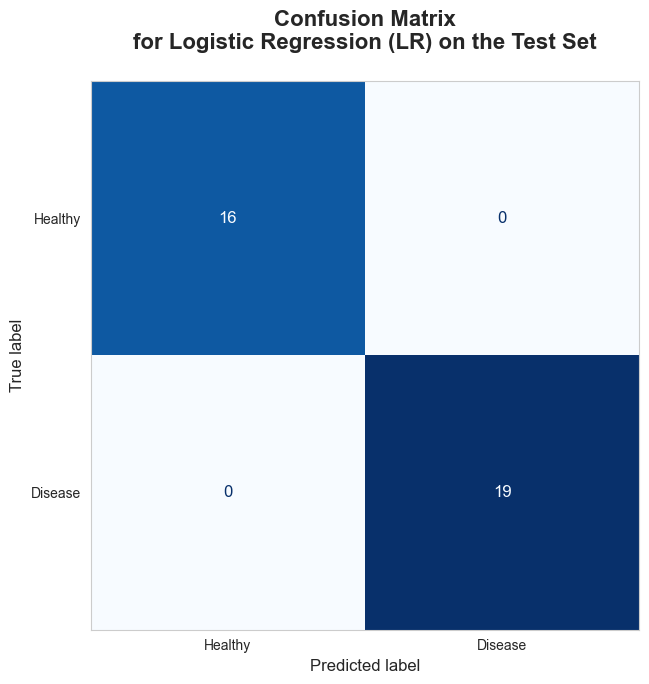

In [13]:
cm_lr = confusion_matrix(y_test, y_pred_lr, labels=[0, 1])
disp_lr = ConfusionMatrixDisplay(
    confusion_matrix=cm_lr,
    display_labels=['Healthy', 'Disease']
)

fig_lr_cm, ax_lr_cm = plt.subplots(figsize=(7, 7))

disp_lr.plot(
    cmap='Blues',
    values_format='d',
    ax=ax_lr_cm,
    colorbar=False
)

ax_lr_cm.grid(False)
ax_lr_cm.set_title(
    'Confusion Matrix\nfor Logistic Regression (LR) on the Test Set\n'
)

fig_lr_cm.tight_layout()
fig_lr_cm.savefig(
    'lr_confusion_matrix.pdf',
    dpi=300,
    bbox_inches='tight'
)
plt.show()

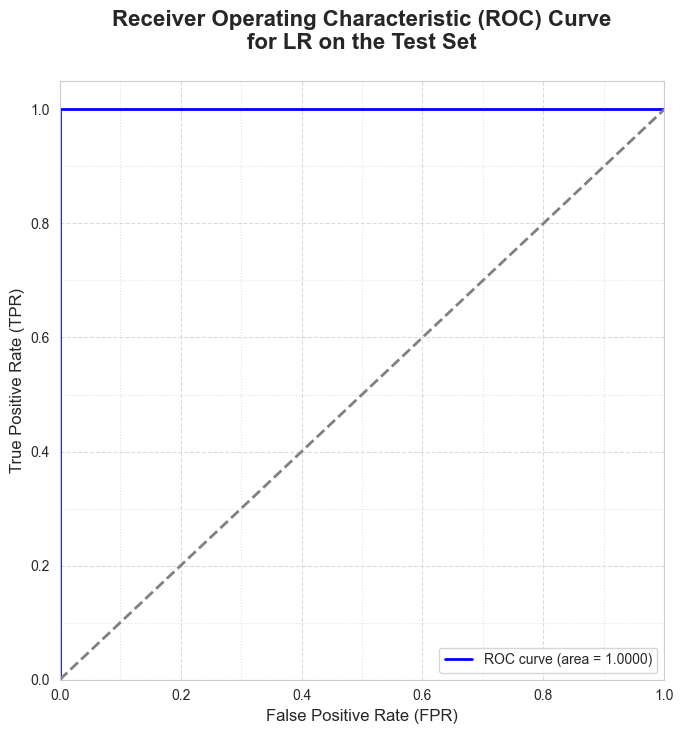

In [14]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_prob_lr)
roc_auc_lr = roc_auc_score(y_test, y_prob_lr)

fig_lr_roc, ax_lr_roc = plt.subplots(figsize=(7, 7.5))

ax_lr_roc.plot(
    fpr_lr,
    tpr_lr,
    color='blue',
    lw=2,
    label=f'ROC curve (area = {roc_auc_lr:.4f})'
)
ax_lr_roc.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

ax_lr_roc.set_title(
    'Receiver Operating Characteristic (ROC) Curve\nfor LR on the Test Set\n'
)
ax_lr_roc.set_xlabel('False Positive Rate (FPR)')
ax_lr_roc.set_ylabel('True Positive Rate (TPR)')
ax_lr_roc.set_xlim([0.0, 1.0])
ax_lr_roc.set_ylim([0.0, 1.05])
ax_lr_roc.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax_lr_roc.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax_lr_roc.grid(which='major', axis='both', linestyle='--', alpha=0.7)
ax_lr_roc.grid(which='minor', axis='both', linestyle=':', alpha=0.6)
ax_lr_roc.legend(loc='lower right')

fig_lr_roc.tight_layout()
fig_lr_roc.savefig(
    'lr_roc_curve.pdf',
    dpi=300,
    bbox_inches='tight'
)
plt.show()

##### _c) Coefficient Analysis_

In [15]:
coefficients = best_lr_model.coef_[0]
feature_names = X_train_scaled.columns
lr_coefficients_df = pd.DataFrame({
    'Gene': feature_names,
    'Coefficient': coefficients
})
lr_coefficients_df['Absolute Coefficient'] = abs(
    lr_coefficients_df['Coefficient']
)

display(Markdown('##### Logistic Regression Coefficient Analysis'))

display(
    Markdown(
        f'**The {N_TOP_TABLE_GENES} Most Influential Genes '
        f'(by absolute coefficient value)**'
    )
)
lr_coefficients_sorted_by_abs = lr_coefficients_df.sort_values(
    by='Absolute Coefficient', ascending=False
)
display(
    lr_coefficients_sorted_by_abs.head(N_TOP_TABLE_GENES)
    .style.format({'Coefficient': '{:.4f}', 'Absolute Coefficient': '{:.4f}'})
    .set_caption('Top Genes by Absolute Coefficient')
    .hide(axis='index')
)

display(
    Markdown(
        f"<br>**The {N_TOP_TABLE_GENES} Genes Positively Associated with 'Disease' "
        f"(Class 1, largest positive coefficients)**"
    )
)
display(
    lr_coefficients_df.sort_values(by='Coefficient', ascending=False)
    .head(N_TOP_TABLE_GENES)
    .style.format({'Coefficient': '{:.4f}', 'Absolute Coefficient': '{:.4f}'})
    .set_caption('Top Positive Coefficients (Disease Association)')
    .hide(axis='index')
)

display(
    Markdown(
        f"<br>**The {N_TOP_TABLE_GENES} Genes Positively Associated with 'Healthy' "
        f"(Class 0, largest negative coefficients)**"
    )
)
display(
    lr_coefficients_df.sort_values(by='Coefficient', ascending=True)
    .head(N_TOP_TABLE_GENES)
    .style.format({'Coefficient': '{:.4f}', 'Absolute Coefficient': '{:.4f}'})
    .set_caption('Top Negative Coefficients (Healthy Association)')
    .hide(axis='index')
)

##### Logistic Regression Coefficient Analysis

**The 20 Most Influential Genes (by absolute coefficient value)**

Gene,Coefficient,Absolute Coefficient
AKR1B10,0.8653,0.8653
S100A7A,0.2387,0.2387
TPBG,0.2300,0.2300
BTC,-0.1448,0.1448
FABP5,0.1421,0.1421
PI3,0.1220,0.1220
SPRR2G,0.1130,0.1130
F3,-0.1044,0.1044
INA,0.0973,0.0973
ABCG4,0.0953,0.0953


<br>**The 20 Genes Positively Associated with 'Disease' (Class 1, largest positive coefficients)**

Gene,Coefficient,Absolute Coefficient
AKR1B10,0.8653,0.8653
S100A7A,0.2387,0.2387
TPBG,0.2300,0.2300
FABP5,0.1421,0.1421
PI3,0.1220,0.1220
SPRR2G,0.1130,0.1130
INA,0.0973,0.0973
ABCG4,0.0953,0.0953
S100A7,0.0806,0.0806
S100A8,0.0799,0.0799


<br>**The 20 Genes Positively Associated with 'Healthy' (Class 0, largest negative coefficients)**

Gene,Coefficient,Absolute Coefficient
BTC,-0.1448,0.1448
F3,-0.1044,0.1044
CHRM4,-0.0643,0.0643
ANKFN1,-0.0364,0.0364
C6orf26,-0.0160,0.0160
COBL,-0.0028,0.0028
ST3GAL6,0.0000,0.0000
COPZ2,0.0000,0.0000
CD46,0.0000,0.0000
SEMA4G,0.0000,0.0000


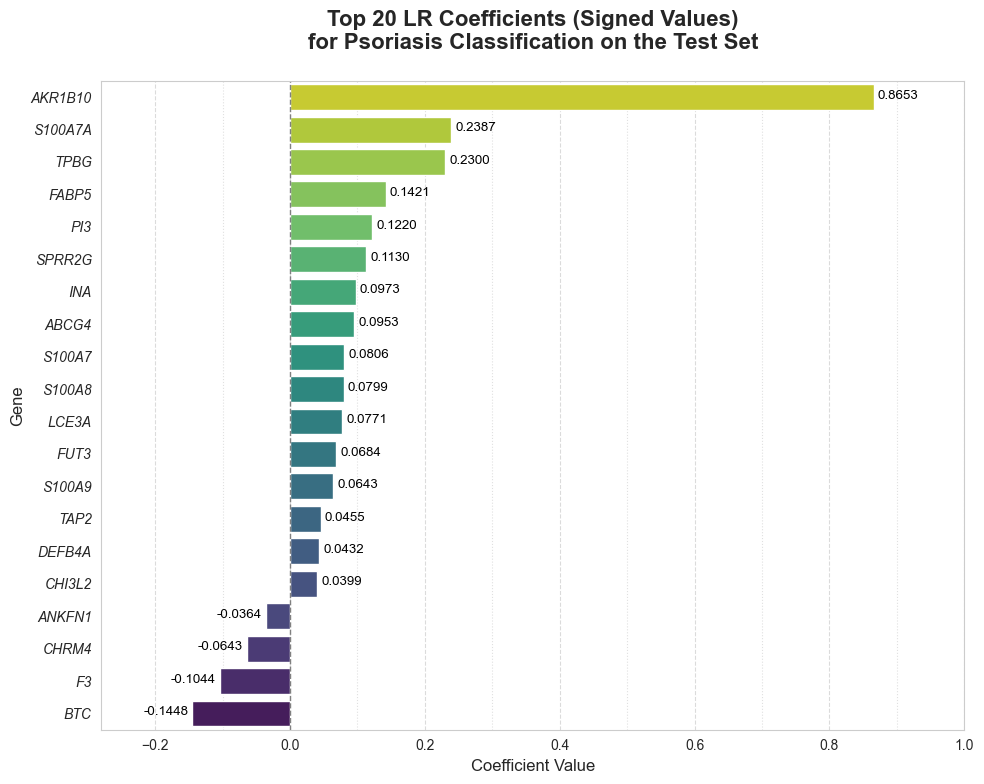

In [16]:
df_viz_lr = (
    lr_coefficients_df.sort_values(by='Absolute Coefficient', ascending=False)
    .head(N_TOP_PLOT_GENES)
)
df_viz_lr = df_viz_lr.sort_values(by='Coefficient', ascending=True)

plot_height = max(6.0, N_TOP_PLOT_GENES * 0.4)
fig_lr_coeffs, ax_lr_coeffs = plt.subplots(figsize=(10, plot_height))

sns.barplot(
    x='Coefficient',
    y='Gene',
    data=df_viz_lr,
    palette='viridis',
    hue='Gene',
    legend=False,
    ax=ax_lr_coeffs
)

ax_lr_coeffs.set_title(
    f'Top {N_TOP_PLOT_GENES} LR Coefficients (Signed Values)\n'
    f'for Psoriasis Classification on the Test Set\n'
)
ax_lr_coeffs.set_xlabel('Coefficient Value')
ax_lr_coeffs.set_ylabel('Gene')
ax_lr_coeffs.set_xlim(-0.28, 1.0)
ax_lr_coeffs.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax_lr_coeffs.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax_lr_coeffs.grid(which='major', axis='x', linestyle='--', alpha=0.7)
ax_lr_coeffs.grid(which='minor', axis='x', linestyle=':', alpha=0.6)
ax_lr_coeffs.grid(axis='y', visible=False)
ax_lr_coeffs.invert_yaxis()
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)

current_locations = ax_lr_coeffs.get_yticks()
current_labels = ax_lr_coeffs.get_yticklabels()
cleaned_and_italic_labels = [
    str(label.get_text()).strip() for label in current_labels
]
ax_lr_coeffs.set_yticks(current_locations)
ax_lr_coeffs.set_yticklabels(cleaned_and_italic_labels, fontstyle='italic')

gap_between_bar_and_label = 0.006
fixed_vertical_label_offset = 0.04
for container in ax_lr_coeffs.containers:
    for bar in container:
        coefficient_value = bar.get_width()
        y_position = (
                bar.get_y() + bar.get_height() / 2 + fixed_vertical_label_offset
        )
        if abs(coefficient_value) > 0.0001:
            ha = 'left' if coefficient_value >= 0 else 'right'
            x_pos = (
                coefficient_value + gap_between_bar_and_label
                if coefficient_value >= 0
                else coefficient_value - gap_between_bar_and_label
            )
            ax_lr_coeffs.text(
                x_pos,
                y_position,
                f'{coefficient_value:.4f}',
                va='center',
                ha=ha,
                color='black',
                fontsize=plt.rcParams['font.size'] * 0.8
            )

fig_lr_coeffs.tight_layout()
fig_lr_coeffs.savefig(
    f'lr_coefficients_top_{N_TOP_PLOT_GENES}.pdf',
    dpi=300,
    bbox_inches='tight'
)
plt.show()

##### _d) SHAP Analysis_

In [17]:
explainer_lr = shap.LinearExplainer(best_lr_model, X_train_scaled)
shap_values_lr = explainer_lr.shap_values(X_test_scaled)

if isinstance(shap_values_lr, list):
    shap_values_positive_lr = shap_values_lr[1]
elif shap_values_lr.ndim == 3:
    shap_values_positive_lr = shap_values_lr[:, :, 1]
else:
    shap_values_positive_lr = shap_values_lr

mean_abs_shap_values_lr = np.mean(np.abs(shap_values_positive_lr), axis=0)
shap_importance_df_lr = pd.DataFrame({
    'Gene': X_train_scaled.columns,
    'Mean Absolute SHAP Value': mean_abs_shap_values_lr
})
shap_importance_df_lr = shap_importance_df_lr.sort_values(
    by='Mean Absolute SHAP Value', ascending=False
)

display(
    Markdown(
        f'**Top {N_TOP_SHAP_DISPLAY} Global Features by Mean Absolute SHAP Value (LR)**'
    )
)
display(
    shap_importance_df_lr.head(N_TOP_SHAP_DISPLAY)
    .style.format({'Mean Absolute SHAP Value': '{:.4f}'})
    .set_caption('Top Genes by Mean Absolute SHAP Value')
    .hide(axis='index')
)

**Top 20 Global Features by Mean Absolute SHAP Value (LR)**

Gene,Mean Absolute SHAP Value
AKR1B10,0.8351
TPBG,0.2350
S100A7A,0.2339
FABP5,0.1548
BTC,0.1381
PI3,0.1180
SPRR2G,0.1072
INA,0.0958
ABCG4,0.0937
F3,0.0926


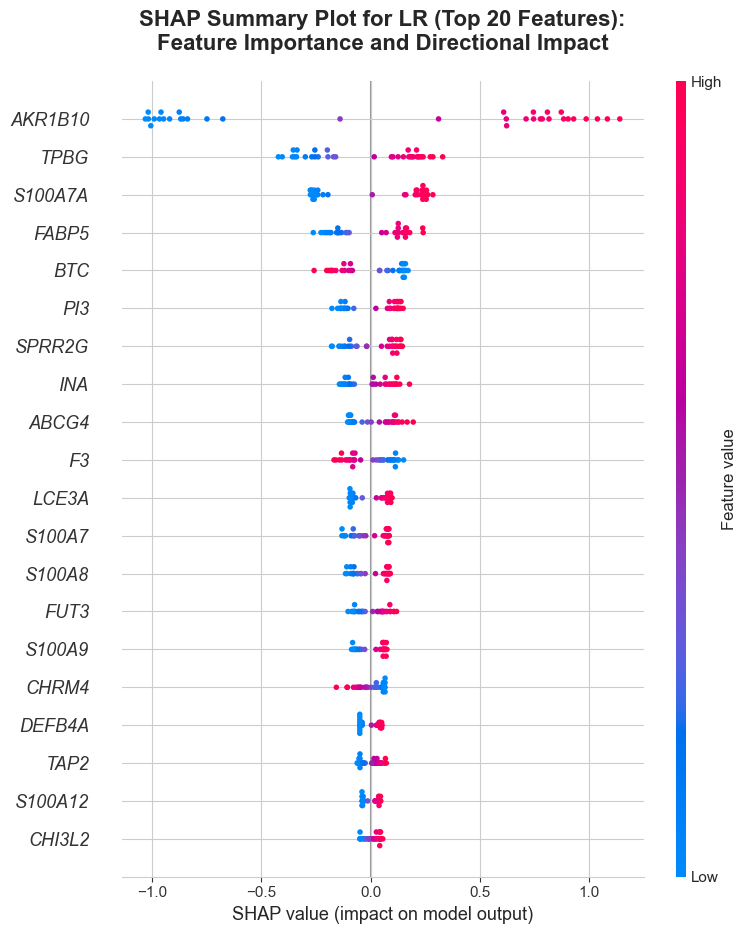

In [18]:
plot_height = max(6.0, N_TOP_SHAP_DISPLAY) * 0.7
fig_lr_shap, ax_lr_shap = plt.subplots(figsize=(10, plot_height))

shap.summary_plot(
    shap_values_positive_lr,
    X_test_scaled, feature_names=X_train_scaled.columns,
    max_display=N_TOP_SHAP_DISPLAY,
    show=False
)

ax_lr_shap.set_title(
    f'SHAP Summary Plot for LR (Top {N_TOP_SHAP_DISPLAY} Features):\n'
    f'Feature Importance and Directional Impact\n'
)

current_locations = ax_lr_shap.get_yticks()
current_labels = ax_lr_shap.get_yticklabels()
cleaned_and_italic_labels = [
    str(label.get_text()).strip() for label in current_labels
]
ax_lr_shap.set_yticks(current_locations)
ax_lr_shap.set_yticklabels(cleaned_and_italic_labels, fontstyle='italic')

fig_lr_shap.tight_layout()
fig_lr_shap.savefig(
    f'lr_shap_summary_top_{N_TOP_SHAP_DISPLAY}.pdf',
    dpi=300,
    bbox_inches='tight'
)
plt.show()

In [19]:
sample_index_disease = y_test[y_test == 1].index[0]
sample_index_healthy = y_test[y_test == 0].index[0]

display(Markdown('**Selected Samples for Individual SHAP Explanations**'))

display(Markdown(f'* **Disease Sample Index:** `{sample_index_disease}`\n'
                 f'* **Healthy Sample Index:** `{sample_index_healthy}`'
                 )
        )

**Selected Samples for Individual SHAP Explanations**

* **Disease Sample Index:** `M8481`
* **Healthy Sample Index:** `M8702`

##### SHAP Explanation for Test Sample `M8481` (Logistic Regression - 'Disease' Sample)

* **True Label:** `1` (0=Healthy, 1=Disease)
* **Model Prediction Probability (Disease=1):** `0.9219`
* **Model Baseline (Expected) Value:** `-0.0024`

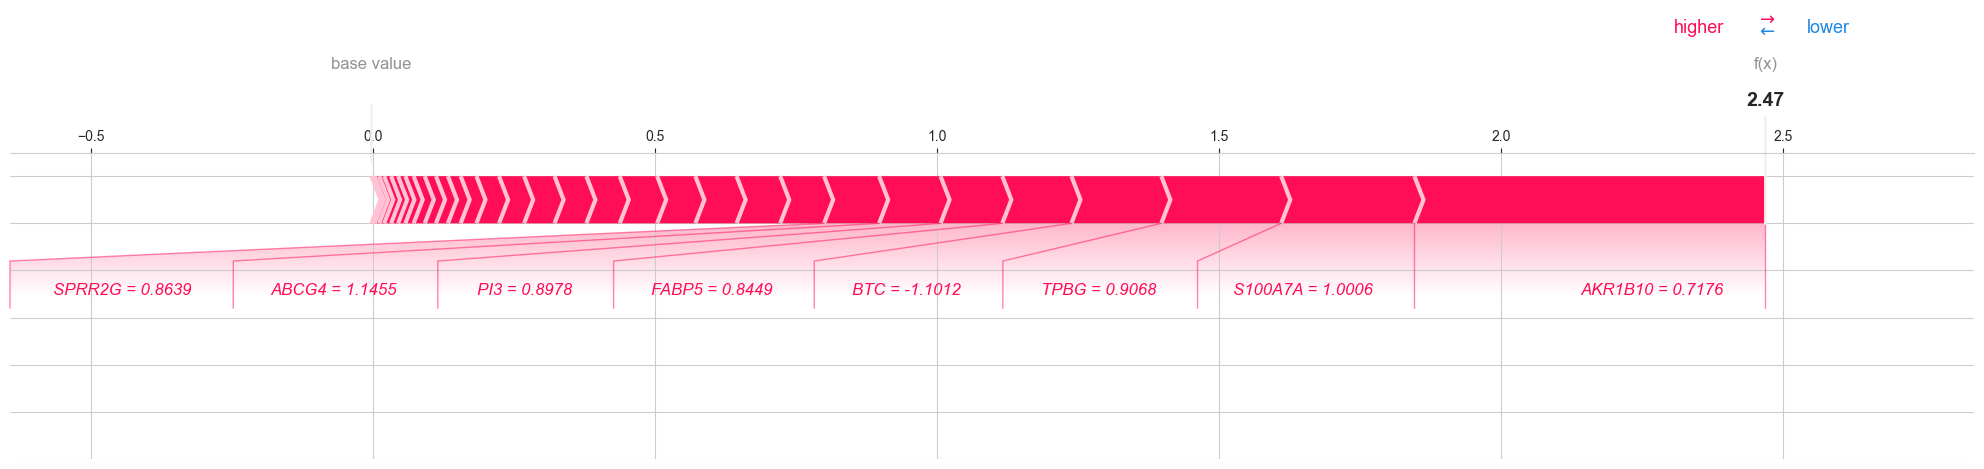

##### SHAP Explanation for Test Sample `M8702` (Logistic Regression - 'Healthy' Sample)

* **True Label:** `0` (0=Healthy, 1=Disease)
* **Model Prediction Probability (Disease=1):** `0.0402`
* **Model Baseline (Expected) Value:** `-0.0024`

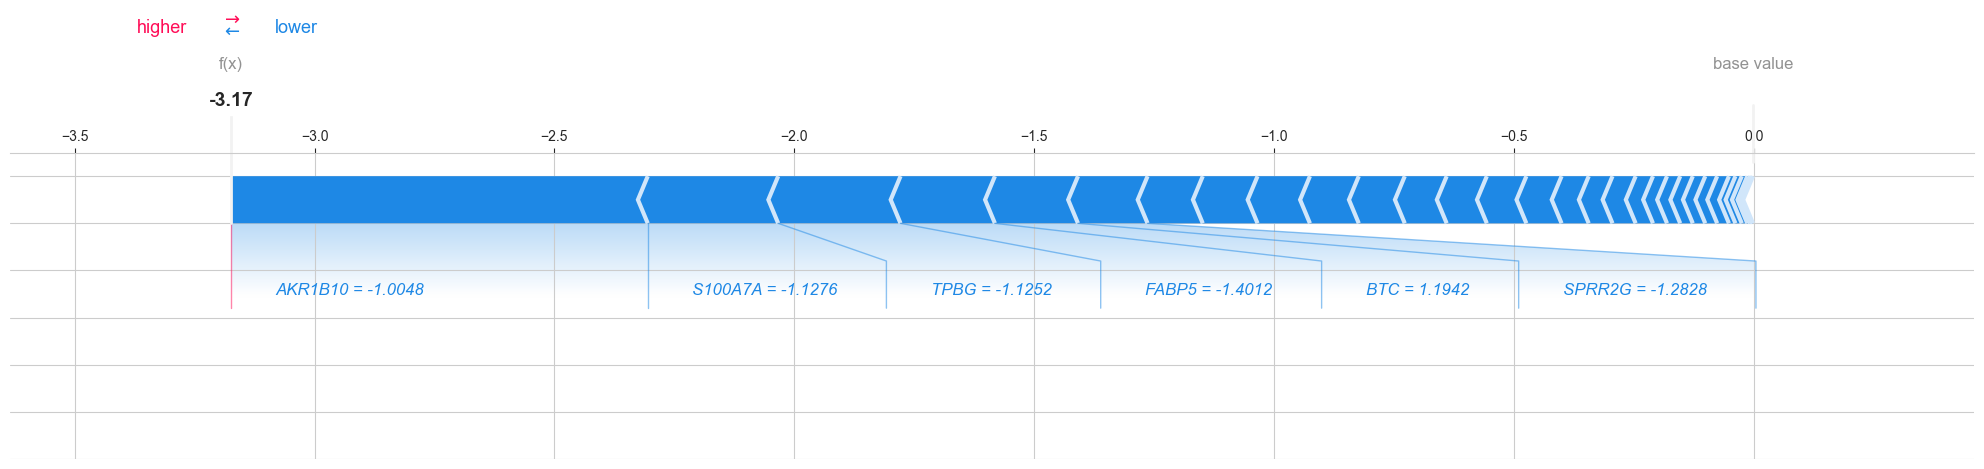

In [20]:
def plot_shap_force_plot(sample_index, model_name='Logistic Regression'):
    """
    Generates, formats and saves a SHAP force plot for a given sample index.
    """
    sample_features = X_test_scaled.loc[[sample_index]]
    individual_shap_values = explainer_lr.shap_values(sample_features)
    prediction_prob = best_lr_model.predict_proba(sample_features)[0, 1]
    true_label_text = 'Disease' if y_test.loc[sample_index] == 1 else 'Healthy'

    display(
        Markdown(
            (f"##### SHAP Explanation for Test Sample `{sample_index}` "
             f"({model_name} - '{true_label_text}' Sample)")
             )
    )

    display(Markdown(f'* **True Label:** `{y_test.loc[sample_index]}` (0=Healthy, 1=Disease)\n'
                     f'* **Model Prediction Probability (Disease=1):** `{prediction_prob:.4f}`\n'
                     f'* **Model Baseline (Expected) Value:** `{explainer_lr.expected_value:.4f}`'
                     )
            )

    shap.force_plot(
        explainer_lr.expected_value,
        individual_shap_values,
        sample_features.round(4),
        matplotlib=True,
        show=False,
        figsize=(20, 5)
    )
    fig_force = plt.gcf()
    ax_force = fig_force.gca()
    gene_names = set(sample_features.columns)
    fig_force.canvas.draw()
    for text_object in ax_force.texts:
        label_text = text_object.get_text()
        if ' = ' in label_text:
            potential_gene_name = label_text.split(' = ')[0].strip()
            if potential_gene_name in gene_names:
                text_object.set_style('italic')

    fig_force.savefig(
        (
            f'lr_shap_force_{true_label_text.lower()}_sample_'
            f'{sample_index}.pdf'
        ),
        dpi=300,
        bbox_inches='tight'
    )
    plt.show()


plot_shap_force_plot(sample_index_disease)
plot_shap_force_plot(sample_index_healthy)

#### 5. Random Forest (RFC) Classification


##### _a) Hyperparameter Tuning_

In [21]:
rf_model = RandomForestClassifier(random_state=RANDOM_STATE)

rf_param_distributions = {
    'n_estimators': randint(50, 500),
    'max_features': ['sqrt', 'log2', 0.6, 0.8, 1.0],
    'max_depth': randint(10, 100),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'bootstrap': [True, False]
}

cv_strategy = StratifiedKFold(
    n_splits=N_SPLITS_CV,
    shuffle=True,
    random_state=RANDOM_STATE
)

with contextlib.suppress(UserWarning):
    rf_random_search = RandomizedSearchCV(
        estimator=rf_model,
        param_distributions=rf_param_distributions,
        n_iter=N_ITER_RANDOM_SEARCH_RF,
        scoring='roc_auc',
        cv=cv_strategy,
        verbose=1,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
rf_random_search.fit(X_train_scaled, y_train)

display(Markdown('**Hyperparameter Tuning Results:**'))
display(Markdown(
    f'* **Best hyperparameters:** `{rf_random_search.best_params_}`\n'
    f'* **Best cross-validation ROC AUC score:** `{rf_random_search.best_score_:.4f}`'
))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


**Hyperparameter Tuning Results:**

* **Best hyperparameters:** `{'bootstrap': True, 'max_depth': 61, 'max_features': 1.0, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 171}`
* **Best cross-validation ROC AUC score:** `1.0000`

##### _b) Performance Metrics and Plots_

In [22]:
best_rf_model = rf_random_search.best_estimator_
y_pred_rf = best_rf_model.predict(X_test_scaled)
y_prob_rf = best_rf_model.predict_proba(X_test_scaled)[:, 1]

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)

display(Markdown('##### Random Forest Classifier Test Set Results'))

display(Markdown('**Key Metrics Summary:**'))
metrics_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC'],
    'Score': [accuracy_rf, precision_rf, recall_rf, f1_rf, roc_auc_rf]
}
metrics_df = pd.DataFrame(metrics_data)
display(
    metrics_df.style.format({'Score': '{:.4f}'})
    .hide(axis='index')
    .set_caption('Performance Metrics Summary')
)

display(Markdown('**Classification Report:**'))
print(classification_report(y_test, y_pred_rf))

##### Random Forest Classifier Test Set Results

**Key Metrics Summary:**

Metric,Score
Accuracy,1.0000
Precision,1.0000
Recall,1.0000
F1-Score,1.0000
ROC AUC,1.0000


**Classification Report:**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        19

    accuracy                           1.00        35
   macro avg       1.00      1.00      1.00        35
weighted avg       1.00      1.00      1.00        35



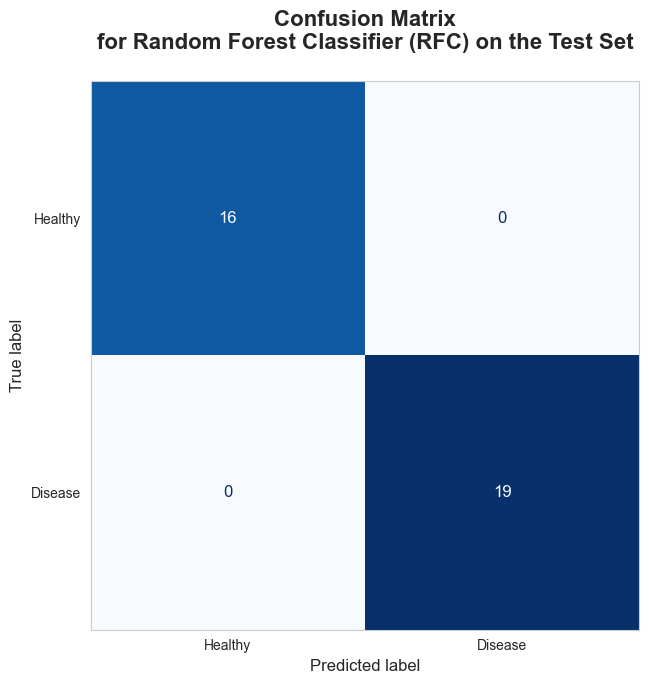

In [23]:
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=[0, 1])
disp_rf = ConfusionMatrixDisplay(
    confusion_matrix=cm_rf,
    display_labels=['Healthy', 'Disease']
)

fig_rf_cm, ax_rf_cm = plt.subplots(figsize=(7, 7))

disp_rf.plot(
    cmap='Blues',
    values_format='d',
    ax=ax_rf_cm,
    colorbar=False
)

ax_rf_cm.grid(False)
ax_rf_cm.set_title(
    'Confusion Matrix\nfor Random Forest Classifier (RFC) on the Test Set\n'
)

fig_rf_cm.tight_layout()
fig_rf_cm.savefig(
    'rf_confusion_matrix.pdf',
    dpi=300,
    bbox_inches='tight'
)
plt.show()

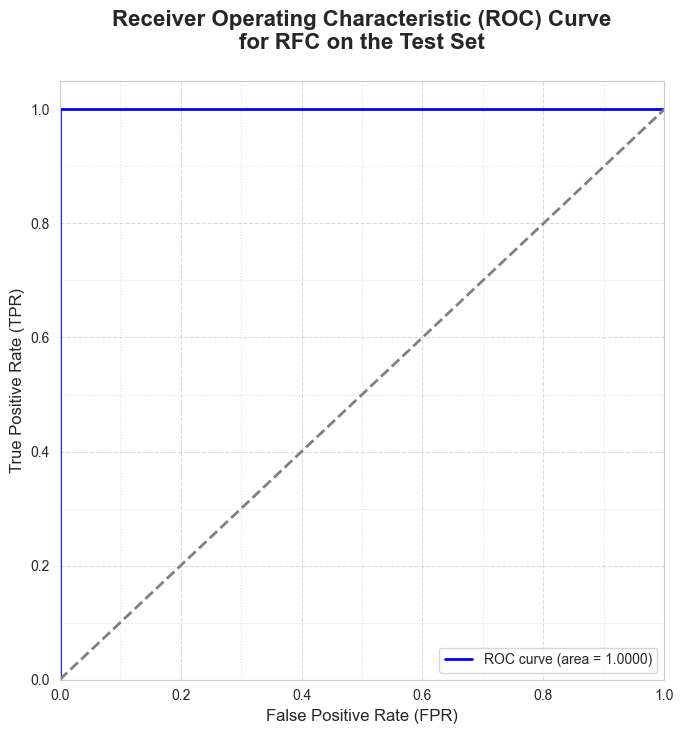

In [24]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_prob_rf)
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)

fig_rf_roc, ax_rf_roc = plt.subplots(figsize=(7, 7.5))

ax_rf_roc.plot(
    fpr_rf,
    tpr_rf,
    color='blue',
    lw=2,
    label=f'ROC curve (area = {roc_auc_rf:.4f})'
)
ax_rf_roc.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

ax_rf_roc.set_title(
    'Receiver Operating Characteristic (ROC) Curve\nfor RFC on the Test Set\n'
)
ax_rf_roc.set_xlabel('False Positive Rate (FPR)')
ax_rf_roc.set_ylabel('True Positive Rate (TPR)')
ax_rf_roc.set_xlim([0.0, 1.0])
ax_rf_roc.set_ylim([0.0, 1.05])
ax_rf_roc.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax_rf_roc.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax_rf_roc.grid(which='major', axis='both', linestyle='--', alpha=0.7)
ax_rf_roc.grid(which='minor', axis='both', linestyle=':', alpha=0.6)
ax_rf_roc.legend(loc='lower right')

fig_rf_roc.tight_layout()
fig_rf_roc.savefig(
    'rf_roc_curve.pdf',
    dpi=300,
    bbox_inches='tight'
)
plt.show()

##### _c) Native Feature Importance Analysis_

In [25]:
importances = best_rf_model.feature_importances_
feature_names = X_train_scaled.columns
rf_feature_importance_df = pd.DataFrame({
    'Gene': feature_names,
    'Native Feature Importance': importances
})
rf_feature_importance_df = rf_feature_importance_df.sort_values(
    by='Native Feature Importance', ascending=False
)

display(Markdown('##### Random Forest Classifier Native Feature Importance'))

display(
    Markdown(
        f'**The {N_TOP_TABLE_GENES} Most Influential Genes '
        f'(by native feature importance):**\n'
    )
)
display(
    rf_feature_importance_df.head(N_TOP_TABLE_GENES)
    .style.format({'Native Feature Importance': '{:.4f}'})
    .set_caption('Top Genes by Native Feature Importance')
    .hide(axis='index')
)

##### Random Forest Classifier Native Feature Importance

**The 20 Most Influential Genes (by native feature importance):**


Gene,Native Feature Importance
COBL,0.0292
CHI3L2,0.0234
ANKRD33B,0.0234
PLA2G4D,0.0234
SPRR2C,0.0234
SNTB1,0.0234
CCR7,0.0234
LCE3A,0.0175
SPRR2A,0.0175
SPRR2G,0.0175


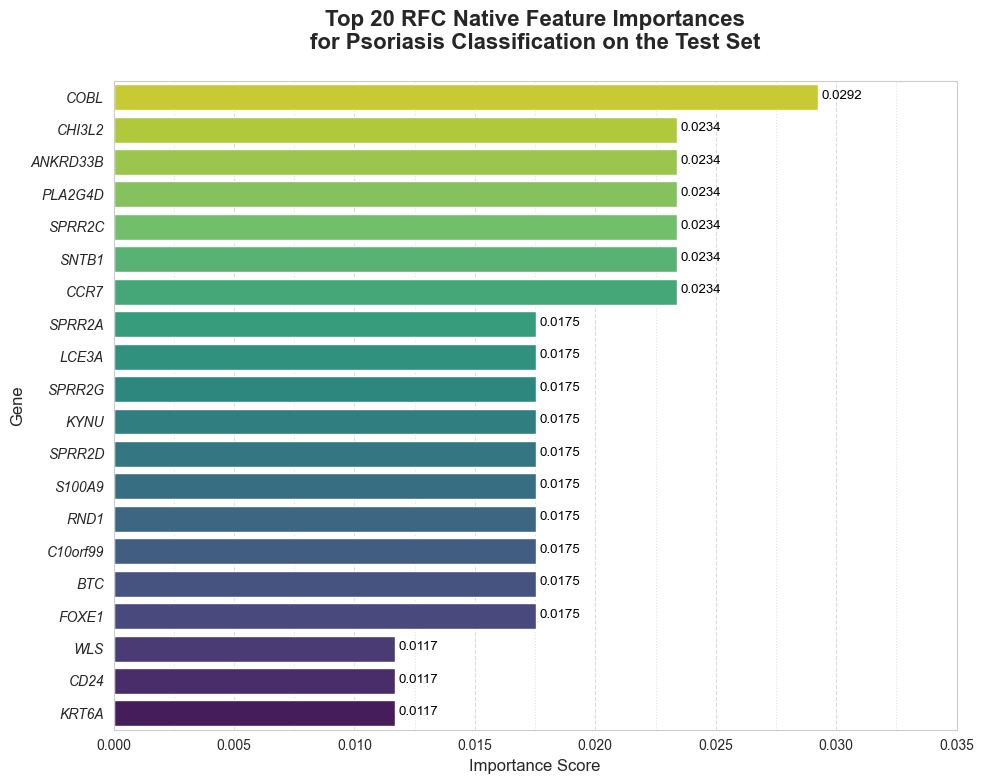

In [26]:
df_viz_rf = (
    rf_feature_importance_df.nlargest(N_TOP_PLOT_GENES, 'Native Feature Importance')
    .sort_values('Native Feature Importance', ascending=True)
)

plot_height = max(6.0, N_TOP_PLOT_GENES * 0.4)
fig_rf_importances, ax_rf_importances = plt.subplots(figsize=(10, plot_height))

sns.barplot(
    x='Native Feature Importance',
    y='Gene',
    data=df_viz_rf,
    palette='viridis',
    hue='Gene',
    legend=False,
    ax=ax_rf_importances
)

ax_rf_importances.set_title(
    f'Top {N_TOP_PLOT_GENES} RFC Native Feature Importances\n'
    f'for Psoriasis Classification on the Test Set\n'
)
ax_rf_importances.set_xlabel('Importance Score')
ax_rf_importances.set_ylabel('Gene')
ax_rf_importances.set_xlim(0.0, 0.035)
ax_rf_importances.xaxis.set_major_locator(ticker.MultipleLocator(0.005))
ax_rf_importances.xaxis.set_minor_locator(ticker.MultipleLocator(0.0025))
ax_rf_importances.grid(which='major', axis='x', linestyle='--', alpha=0.7)
ax_rf_importances.grid(which='minor', axis='x', linestyle=':', alpha=0.6)
ax_rf_importances.grid(axis='y', visible=False)
ax_rf_importances.invert_yaxis()

current_locations = ax_rf_importances.get_yticks()
current_labels = ax_rf_importances.get_yticklabels()
cleaned_and_italic_labels = [
    str(label.get_text()).strip() for label in current_labels
]
ax_rf_importances.set_yticks(current_locations)
ax_rf_importances.set_yticklabels(cleaned_and_italic_labels, fontstyle='italic')

gap_between_bar_and_label = 0.00015
fixed_vertical_label_offset = 0.04
for container in ax_rf_importances.containers:
    for bar in container:
        importance_value = bar.get_width()
        y_position = bar.get_y() + bar.get_height() / 2 + fixed_vertical_label_offset

        ax_rf_importances.text(
            importance_value + gap_between_bar_and_label, y_position,
            f'{importance_value:.4f}',
            va='center',
            ha='left',
            color='black',
            fontsize=plt.rcParams['font.size'] * 0.8
            )

fig_rf_importances.tight_layout()
fig_rf_importances.savefig(
    f'rf_feature_importance_top_{N_TOP_PLOT_GENES}.pdf',
    dpi=300,
    bbox_inches='tight'
)
plt.show()

##### _d) SHAP Analysis_

In [27]:
explainer_rf = shap.TreeExplainer(best_rf_model, X_train_scaled)
shap_values_rf = explainer_rf.shap_values(X_test_scaled)

if isinstance(shap_values_rf, list):
    shap_values_positive_rf = shap_values_rf[1]
elif shap_values_rf.ndim == 3:
    shap_values_positive_rf = shap_values_rf[:, :, 1]
else:
    shap_values_positive_rf = shap_values_rf

mean_abs_shap_values_rf = np.mean(np.abs(shap_values_positive_rf), axis=0)
shap_importance_df_rf = pd.DataFrame({
    'Gene': X_train_scaled.columns,
    'Mean Absolute SHAP Value': mean_abs_shap_values_rf
})
shap_importance_df_rf = shap_importance_df_rf.sort_values(
    by='Mean Absolute SHAP Value', ascending=False
)

display(
    Markdown(
        f'**Top {N_TOP_SHAP_DISPLAY} Global Features by Mean Absolute SHAP Value (RFC)**'
    )
)
display(
    shap_importance_df_rf.head(N_TOP_SHAP_DISPLAY)
    .style.format({'Mean Absolute SHAP Value': '{:.4f}'})
    .set_caption('Top Genes by Mean Absolute SHAP Value')
    .hide(axis='index')
)

**Top 20 Global Features by Mean Absolute SHAP Value (RFC)**

Gene,Mean Absolute SHAP Value
COBL,0.0146
ANKRD33B,0.0117
PLA2G4D,0.0116
SPRR2C,0.0116
SNTB1,0.0115
CCR7,0.0112
CHI3L2,0.0112
C10orf99,0.0087
KYNU,0.0087
LCE3A,0.0087


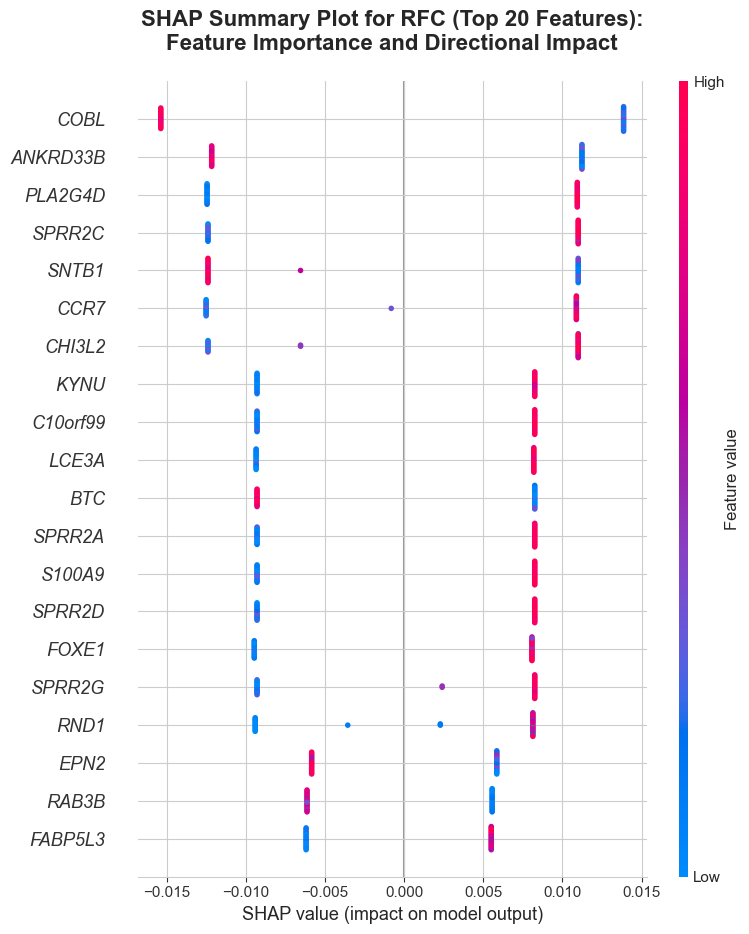

In [28]:
plot_height = max(6.0, N_TOP_SHAP_DISPLAY) * 0.7
fig_rf_shap, ax_rf_shap = plt.subplots(figsize=(10, plot_height))

shap.summary_plot(
    shap_values_positive_rf,
    X_test_scaled,
    feature_names=X_train_scaled.columns,
    max_display=N_TOP_SHAP_DISPLAY,
    show=False
)

ax_rf_shap.set_title(
    f'SHAP Summary Plot for RFC (Top {N_TOP_SHAP_DISPLAY} Features):\n'
    f'Feature Importance and Directional Impact\n'
)

current_locations = ax_rf_shap.get_yticks()
current_labels = ax_rf_shap.get_yticklabels()
cleaned_and_italic_labels = [
    str(label.get_text()).strip() for label in current_labels
]
ax_rf_shap.set_yticks(current_locations)
ax_rf_shap.set_yticklabels(cleaned_and_italic_labels, fontstyle='italic')

fig_rf_shap.tight_layout()
fig_rf_shap.savefig(
    f'rf_shap_summary_top_{N_TOP_SHAP_DISPLAY}.pdf',
    dpi=300,
    bbox_inches='tight'
)
plt.show()

#### 6. Support Vector Machine (SVM) Classification

##### _a) Hyperparameter Tuning_

In [29]:
svm_model = SVC(
    random_state=RANDOM_STATE,
    probability=True
)

svm_param_distributions = {
    'C': loguniform(1e-1, 1e2),
    'kernel': ['linear', 'rbf'],
    'gamma': loguniform(1e-4, 1e0)
}

cv_strategy = StratifiedKFold(
    n_splits=N_SPLITS_CV,
    shuffle=True,
    random_state=RANDOM_STATE
)

with contextlib.suppress(UserWarning):
    svm_random_search = RandomizedSearchCV(
        estimator=svm_model,
        param_distributions=svm_param_distributions,
        n_iter=N_ITER_RANDOM_SEARCH_SVM,
        scoring='roc_auc',
        cv=cv_strategy,
        verbose=1,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
svm_random_search.fit(X_train_scaled, y_train)

display(Markdown('**Hyperparameter Tuning Results:**'))
display(Markdown(
    f'* **Best hyperparameters:** `{svm_random_search.best_params_}`\n'
    f'* **Best cross-validation ROC AUC score:** `{svm_random_search.best_score_:.4f}`'
))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


**Hyperparameter Tuning Results:**

* **Best hyperparameters:** `{'C': np.float64(1.3292918943162166), 'gamma': np.float64(0.6351221010640696), 'kernel': 'linear'}`
* **Best cross-validation ROC AUC score:** `1.0000`

##### _b) Performance Metrics and Plots_

In [30]:
best_svm_model = svm_random_search.best_estimator_
y_pred_svm = best_svm_model.predict(X_test_scaled)
y_prob_svm = best_svm_model.predict_proba(X_test_scaled)[:, 1]

accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
roc_auc_svm = roc_auc_score(y_test, y_prob_svm)

display(Markdown('##### Support Vector Machine Test Set Results'))

display(Markdown('**Key Metrics Summary:**'))
metrics_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC'],
    'Score': [accuracy_svm, precision_svm, recall_svm, f1_svm, roc_auc_svm]
}
metrics_df = pd.DataFrame(metrics_data)
display(
    metrics_df.style.format({'Score': '{:.4f}'})
    .hide(axis='index')
    .set_caption('Performance Metrics Summary')
)

display(Markdown('**Classification Report:**'))
print(classification_report(y_test, y_pred_svm))

##### Support Vector Machine Test Set Results

**Key Metrics Summary:**

Metric,Score
Accuracy,1.0000
Precision,1.0000
Recall,1.0000
F1-Score,1.0000
ROC AUC,1.0000


**Classification Report:**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        19

    accuracy                           1.00        35
   macro avg       1.00      1.00      1.00        35
weighted avg       1.00      1.00      1.00        35



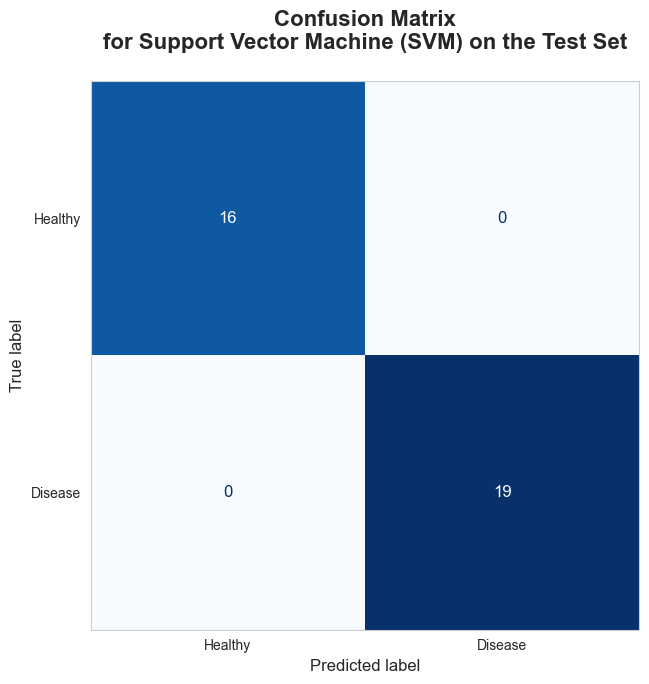

In [31]:
cm_svm = confusion_matrix(y_test, y_pred_svm, labels=[0, 1])
disp_svm = ConfusionMatrixDisplay(
    confusion_matrix=cm_svm,
    display_labels=['Healthy', 'Disease']
)

fig_svm_cm, ax_svm_cm = plt.subplots(figsize=(7, 7))

disp_svm.plot(
    cmap='Blues',
    values_format='d',
    ax=ax_svm_cm,
    colorbar=False
)

ax_svm_cm.grid(False)
ax_svm_cm.set_title(
    'Confusion Matrix\nfor Support Vector Machine (SVM) on the Test Set\n'
)

fig_svm_cm.tight_layout()
fig_svm_cm.savefig(
    'svm_confusion_matrix.pdf',
    dpi=300,
    bbox_inches='tight'
)
plt.show()

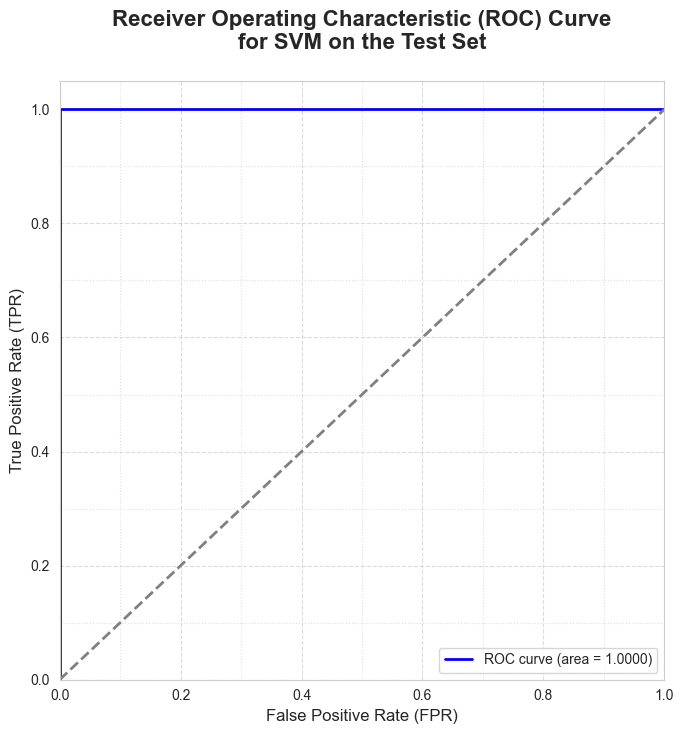

In [32]:
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_prob_svm)
roc_auc_svm = roc_auc_score(y_test, y_prob_svm)

fig_svm_roc, ax_svm_roc = plt.subplots(figsize=(7, 7.5))

ax_svm_roc.plot(
    fpr_svm,
    tpr_svm,
    color='blue',
    lw=2,
    label=f'ROC curve (area = {roc_auc_svm:.4f})'
)
ax_svm_roc.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

ax_svm_roc.set_title(
    'Receiver Operating Characteristic (ROC) Curve\nfor SVM on the Test Set\n'
)
ax_svm_roc.set_xlabel('False Positive Rate (FPR)')
ax_svm_roc.set_ylabel('True Positive Rate (TPR)')
ax_svm_roc.set_xlim([0.0, 1.0])
ax_svm_roc.set_ylim([0.0, 1.05])
ax_svm_roc.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax_svm_roc.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax_svm_roc.grid(which='major', axis='both', linestyle='--', alpha=0.7)
ax_svm_roc.grid(which='minor', axis='both', linestyle=':', alpha=0.6)
ax_svm_roc.legend(loc='lower right')

fig_svm_roc.tight_layout()
fig_svm_roc.savefig(
    'svm_roc_curve.pdf',
    dpi=300,
    bbox_inches='tight'
)
plt.show()

##### _c) SHAP Analysis_

In [33]:
background_data_svm = shap.kmeans(X_train_scaled, K_MEANS_SHAP_SAMPLES)
explainer_svm = shap.KernelExplainer(best_svm_model.predict_proba, background_data_svm)
shap_values_svm = explainer_svm.shap_values(X_test_scaled)

if isinstance(shap_values_svm, list):
    shap_values_positive_svm = shap_values_svm[1]
elif shap_values_svm.ndim == 3:
    shap_values_positive_svm = shap_values_svm[:, :, 1]
else:
    shap_values_positive_svm = shap_values_svm

mean_abs_shap_values_svm = np.mean(np.abs(shap_values_positive_svm), axis=0)
shap_importance_df_svm = pd.DataFrame({
    'Gene': X_train_scaled.columns,
    'Mean Absolute SHAP Value': mean_abs_shap_values_svm
})
shap_importance_df_svm = shap_importance_df_svm.sort_values(
    by='Mean Absolute SHAP Value', ascending=False
)

display(
    Markdown(
        f'**Top {N_TOP_SHAP_DISPLAY} Global Features by Mean Absolute SHAP Value (SVM)**'
    )
)
display(
    shap_importance_df_svm.head(N_TOP_SHAP_DISPLAY)
    .style.format({'Mean Absolute SHAP Value': '{:.4f}'})
    .set_caption('Top Genes by Mean Absolute SHAP Value')
    .hide(axis='index')
)

  0%|          | 0/35 [00:00<?, ?it/s]

**Top 20 Global Features by Mean Absolute SHAP Value (SVM)**

Gene,Mean Absolute SHAP Value
SENP7,0.0030
IGFL1,0.0029
STAT1,0.0028
HPGDS,0.0028
PMCH,0.0028
EPS8L1,0.0027
AMY2B,0.0027
GTSE1,0.0027
APOC2,0.0027
C1orf31,0.0027


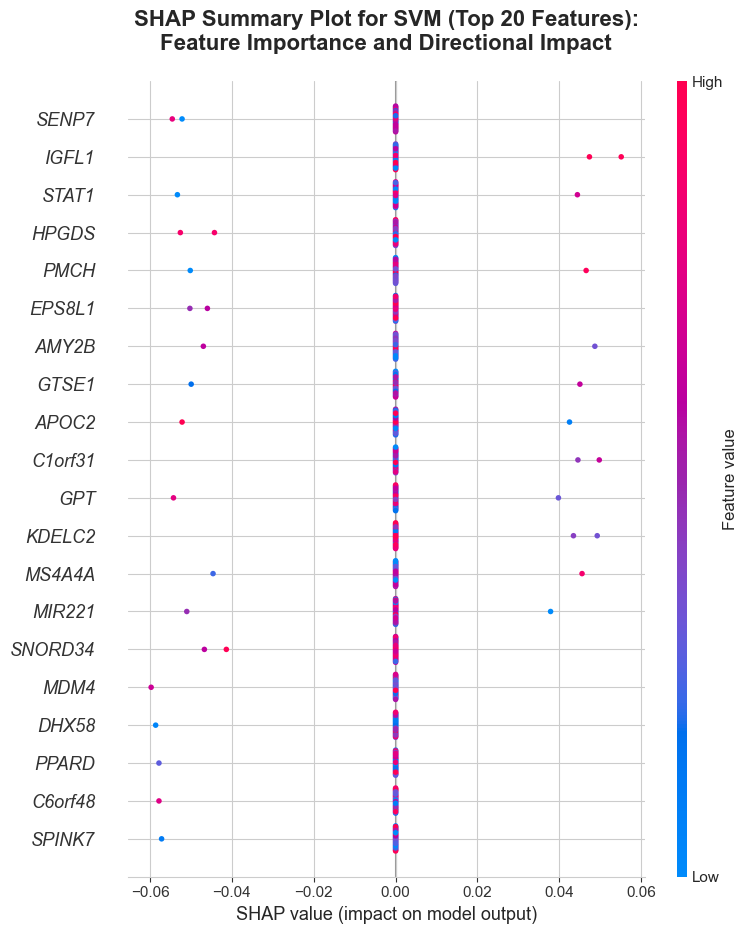

In [34]:
plot_height = max(6.0, N_TOP_SHAP_DISPLAY) * 0.7
fig_svm_shap, ax_svm_shap = plt.subplots(figsize=(10, plot_height))

shap.summary_plot(
    shap_values_positive_svm,
    X_test_scaled,
    feature_names=X_train_scaled.columns,
    max_display=N_TOP_SHAP_DISPLAY,
    show=False
)

ax_svm_shap.set_title(
    f'SHAP Summary Plot for SVM (Top {N_TOP_SHAP_DISPLAY} Features):\n'
    f'Feature Importance and Directional Impact\n'
)

current_locations = ax_svm_shap.get_yticks()
current_labels = ax_svm_shap.get_yticklabels()
cleaned_and_italic_labels = [
    str(label.get_text()).strip() for label in current_labels
]
ax_svm_shap.set_yticks(current_locations)
ax_svm_shap.set_yticklabels(cleaned_and_italic_labels, fontstyle='italic')

fig_svm_shap.tight_layout()
fig_svm_shap.savefig(
    f'svm_shap_summary_top_{N_TOP_SHAP_DISPLAY}.pdf',
    dpi=300,
    bbox_inches='tight'
)
plt.show()

#### 7. Overall Model Comparison and Feature Analysis

##### _a) Model Performance Comparison_

In [35]:
display(
    Markdown('#### Comparative Summary of Model Performance Metrics'))
display(
    Markdown('This table summarises the performance of each model on the'
                 'held-out test set across key classification metrics.')
)

results_summary = [
    {'Model': 'Logistic Regression',
     'ROC AUC': roc_auc_lr,
     'Accuracy': accuracy_lr,
     'Precision': precision_lr,
     'Recall': recall_lr,
     'F1-Score': f1_lr,},

    {'Model': 'Random Forest Classifier',
     'ROC AUC': roc_auc_rf,
     'Accuracy': accuracy_rf,
     'Precision': precision_rf,
     'Recall': recall_rf,
     'F1-Score': f1_rf,},

    {'Model': 'Support Vector Machine',
     'ROC AUC': roc_auc_svm,
     'Accuracy': accuracy_svm,
     'Precision': precision_svm,
     'Recall': recall_svm,
     'F1-Score': f1_svm,}
]

df_performance_summary = pd.DataFrame(results_summary)

df_performance_summary = df_performance_summary.set_index('Model')

display(
    df_performance_summary.style.format('{:.4f}')
    .set_caption('Model Performance on Test Set')
    .highlight_max(axis=0, props='font-weight: bold;')
)

#### Comparative Summary of Model Performance Metrics

This table summarises the performance of each model on theheld-out test set across key classification metrics.

,ROC AUC,Accuracy,Precision,Recall,F1-Score
Model,,,,,
Logistic Regression,1.0000,1.0000,1.0000,1.0000,1.0000
Random Forest Classifier,1.0000,1.0000,1.0000,1.0000,1.0000
Support Vector Machine,1.0000,1.0000,1.0000,1.0000,1.0000


##### _b) Consolidated Feature Importance (Table)_

In [36]:
top_lr_coeffs = (lr_coefficients_df.sort_values(by='Absolute Coefficient', ascending=False)
                 .head(N_GENES_FOR_CONSOLIDATION))
top_rf_importances = rf_feature_importance_df.head(N_GENES_FOR_CONSOLIDATION)
top_lr_shap = shap_importance_df_lr.head(N_GENES_FOR_CONSOLIDATION)
top_rf_shap = shap_importance_df_rf.head(N_GENES_FOR_CONSOLIDATION)
top_svm_shap = shap_importance_df_svm.head(N_GENES_FOR_CONSOLIDATION)

gene_series_to_concat = [
    top_lr_coeffs['Gene'],
    top_rf_importances['Gene'],
    top_lr_shap['Gene'],
    top_rf_shap['Gene'],
    top_svm_shap['Gene']
]

all_top_genes = pd.concat(gene_series_to_concat).unique()
combined_feature_summary = pd.DataFrame({'Gene': all_top_genes})

importance_dfs_to_merge = [
    (top_lr_coeffs, 'Coefficient', 'LR Coefficient'),
    (top_rf_importances, 'Native Feature Importance', 'RFC Native Feature Importance'),
    (top_lr_shap, 'Mean Absolute SHAP Value', 'LR SHAP Value'),
    (top_rf_shap, 'Mean Absolute SHAP Value', 'RFC SHAP Value'),
    (top_svm_shap, 'Mean Absolute SHAP Value', 'SVM SHAP Value')
]
for df, col_name, new_col_name in importance_dfs_to_merge:
    combined_feature_summary = pd.merge(combined_feature_summary,
                                        df[['Gene', col_name]].rename(columns={col_name: new_col_name}),
                                        on='Gene',
                                        how='left')

combined_feature_summary = combined_feature_summary.fillna(0)

columns_to_normalise = [
    'LR Coefficient',
    'RFC Native Feature Importance',
    'LR SHAP Value',
    'RFC SHAP Value',
    'SVM SHAP Value'
]

data_to_normalise = combined_feature_summary[columns_to_normalise].abs()

scaler = MinMaxScaler()
normalised_scores = scaler.fit_transform(data_to_normalise)
normalised_df = pd.DataFrame(normalised_scores, columns=columns_to_normalise)
normalised_df['Gene'] = combined_feature_summary['Gene']
normalised_df['Consensus Score'] = normalised_df[columns_to_normalise].sum(axis=1)
df_final_summary = normalised_df.sort_values(by='Consensus Score', ascending=False)

columns_to_display = ['Gene', 'Consensus Score'] + columns_to_normalise
df_final_summary = df_final_summary[columns_to_display]

display(
    Markdown('#### Consolidated Top Gene Features Across Models'))
display(
    Markdown('This table ranks the most influential genes based on a normalised '
             'consensus score aggregated from all models and methods.')
)

numeric_cols = df_final_summary.select_dtypes(include=np.number).columns
formatter = {col: '{:.4f}' for col in numeric_cols}

display(
    df_final_summary.head(N_GENES_FOR_SUMMARY_TABLE)
    .style.format(formatter)
    .set_caption('Top Genes by Normalised Consensus Score')
    .background_gradient(subset=['Consensus Score'], cmap='viridis')
    .hide(axis='index')
)

#### Consolidated Top Gene Features Across Models

This table ranks the most influential genes based on a normalised consensus score aggregated from all models and methods.

Gene,Consensus Score,LR Coefficient,RFC Native Feature Importance,LR SHAP Value,RFC SHAP Value,SVM SHAP Value
AKR1B10,2.0000,1.0000,0.0000,1.0000,0.0000,0.0000
COBL,2.0000,0.0000,1.0000,0.0000,1.0000,0.0000
CHI3L2,1.6533,0.0461,0.8000,0.0389,0.7682,0.0000
ANKRD33B,1.6008,0.0000,0.8000,0.0000,0.8008,0.0000
PLA2G4D,1.5991,0.0000,0.8000,0.0000,0.7991,0.0000
SPRR2C,1.5967,0.0000,0.8000,0.0000,0.7967,0.0000
SNTB1,1.5935,0.0000,0.8000,0.0000,0.7935,0.0000
CCR7,1.5726,0.0000,0.8000,0.0000,0.7726,0.0000
BTC,1.5302,0.1674,0.6000,0.1654,0.5975,0.0000
SPRR2G,1.4294,0.1305,0.6000,0.1284,0.5704,0.0000


##### _c) Consolidated Feature Importance (Plot)_

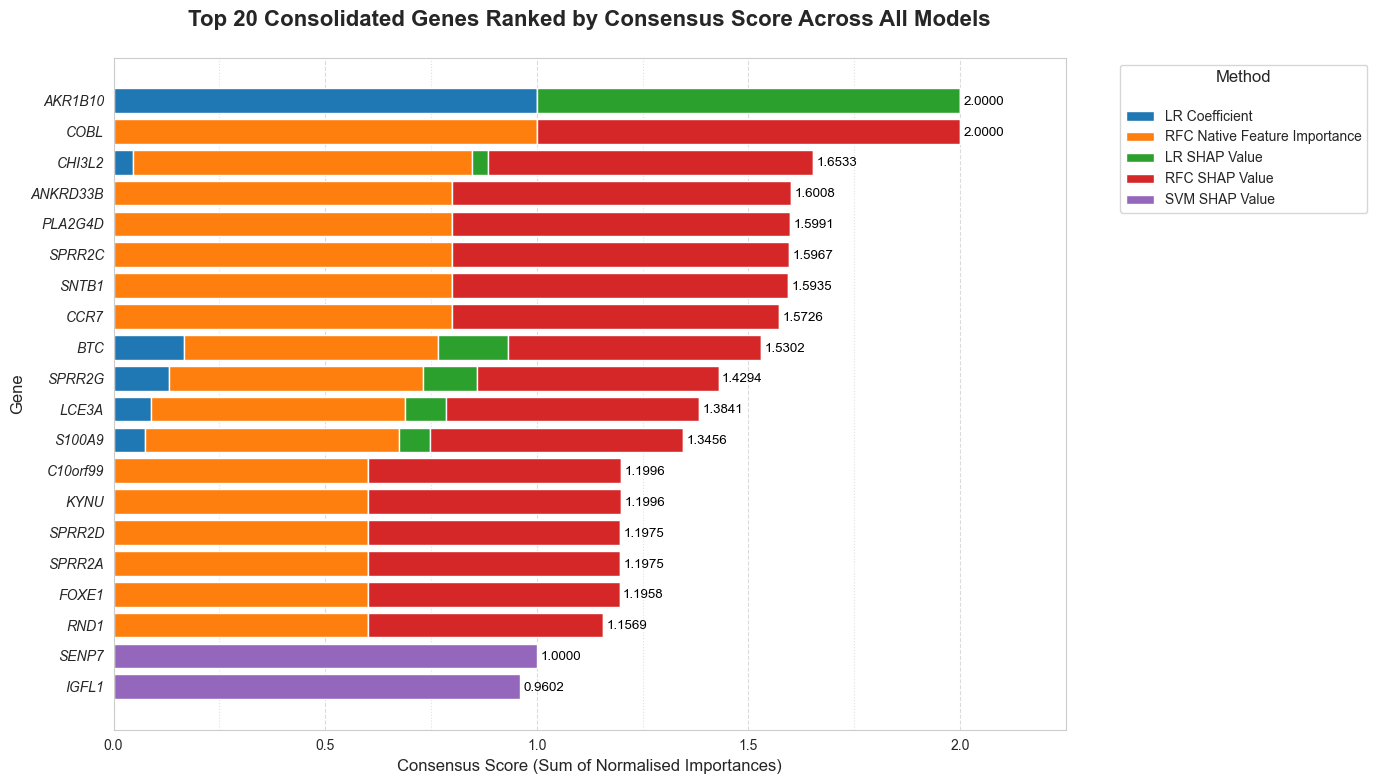

In [37]:
df_plot_base = df_final_summary.head(N_GENES_FOR_SUMMARY_PLOT).copy()

importance_methods = [
    'LR Coefficient',
    'RFC Native Feature Importance',
    'LR SHAP Value',
    'RFC SHAP Value',
    'SVM SHAP Value'
]

ordered_gene_names = (
    df_plot_base.sort_values(by='Consensus Score', ascending=True)['Gene'].tolist()
)

plot_height = max(6.0, N_GENES_FOR_SUMMARY_PLOT * 0.4)
fig_consensus, ax_consensus = plt.subplots(figsize=(14, plot_height))

left_offset = np.zeros(len(ordered_gene_names))

for method in importance_methods:
    subset_data = df_plot_base.set_index('Gene').loc[ordered_gene_names].reset_index()
    ax_consensus.barh(
        ordered_gene_names,
        subset_data[method],
        left=left_offset,
        label=method
    )
    left_offset += subset_data[method].values

ax_consensus.set_title(
    f'Top {N_GENES_FOR_SUMMARY_PLOT} Consolidated Genes Ranked by Consensus Score Across All Models\n',
    fontsize=plt.rcParams['axes.titlesize']
)
ax_consensus.set_xlabel('Consensus Score (Sum of Normalised Importances)')
ax_consensus.set_ylabel('Gene')

max_score_actual = df_plot_base['Consensus Score'].max()
ax_consensus.set_xlim(0, max_score_actual + 0.25)
ax_consensus.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax_consensus.xaxis.set_minor_locator(ticker.MultipleLocator(0.25))

ax_consensus.grid(which='major', axis='x', linestyle='--', alpha=0.7)
ax_consensus.grid(which='minor', axis='x', linestyle=':', alpha=0.6)
ax_consensus.grid(axis='y', visible=False)

ax_consensus.legend(
    title='Method\n',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    frameon=True,
    facecolor='white',
    edgecolor=plt.rcParams['grid.color']
)

tick_locations = np.arange(len(ordered_gene_names))
ax_consensus.set_yticks(tick_locations)
ax_consensus.set_yticklabels(ordered_gene_names, fontstyle='italic')

gap_between_bar_and_label = 0.008
fixed_vertical_label_offset = -0.04
for i, gene in enumerate(ordered_gene_names):
    final_score = df_plot_base[df_plot_base['Gene'] == gene]['Consensus Score'].iloc[0]
    ax_consensus.text(
        final_score + gap_between_bar_and_label,
        i + fixed_vertical_label_offset,
        f'{final_score:.4f}',
        va='center',
        ha='left',
        color='black',
        fontsize=plt.rcParams['font.size'] * 0.8
    )

fig_consensus.tight_layout()
plt.savefig(
    f'consensus_score_top_{N_GENES_FOR_SUMMARY_PLOT}_genes.pdf',
    dpi=300,
    bbox_inches='tight'
)
plt.show()

##### _d) Feature Overlap Analysis (Tables)_

In [38]:
gene_sets = {
    'LR Coefficient': set(top_lr_coeffs['Gene']),
    'RFC Native Feature Importance': set(top_rf_importances['Gene']),
    'LR SHAP Value': set(top_lr_shap['Gene']),
    'RFC SHAP Value': set(top_rf_shap['Gene']),
    'SVM SHAP Value': set(top_svm_shap['Gene'])
}
all_methods = list(gene_sets.keys())

for num_to_combine in range(2, len(all_methods) + 1):
    if num_to_combine == 2:
        display(
            Markdown(f'###### Pairwise Overlaps (Genes Common to {num_to_combine} Methods)')
        )
    elif num_to_combine == len(all_methods):
        display(
            Markdown(f'###### Genes Common to ALL ({num_to_combine}) Methods')
        )
    else:
        display(
            Markdown(f'###### Genes Common to {num_to_combine} Methods')
        )

    overlap_results = []
    for combo in itertools.combinations(all_methods, num_to_combine):
        overlap = set.intersection(*[gene_sets[method] for method in combo])
        if len(overlap) > 0:
            overlap_results.append({
                'Methods': ', '.join(combo),
                'Overlap Count': len(overlap),
                'Common Genes': ', '.join(sorted(list(overlap)))
            })
    if overlap_results:
        df_overlaps = pd.DataFrame(overlap_results)
        display(
            df_overlaps.style
            .set_caption(f'Gene Overlaps Found Across {num_to_combine} Methods')
            .set_properties(**{'text-align': 'left'})
            .set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
            .hide(axis='index')
        )
    else:
        print(f'  No common genes found for any combination of '
                  f'{num_to_combine} methods.')
    if num_to_combine < len(all_methods):
        display(Markdown('---'))

###### Pairwise Overlaps (Genes Common to 2 Methods)

Methods,Overlap Count,Common Genes
"LR Coefficient, RFC Native Feature Importance",5,"BTC, CHI3L2, LCE3A, S100A9, SPRR2G"
"LR Coefficient, LR SHAP Value",19,"ABCG4, AKR1B10, BTC, CHI3L2, CHRM4, DEFB4A, F3, FABP5, FUT3, INA, LCE3A, PI3, S100A7, S100A7A, S100A8, S100A9, SPRR2G, TAP2, TPBG"
"LR Coefficient, RFC SHAP Value",5,"BTC, CHI3L2, LCE3A, S100A9, SPRR2G"
"RFC Native Feature Importance, LR SHAP Value",5,"BTC, CHI3L2, LCE3A, S100A9, SPRR2G"
"RFC Native Feature Importance, RFC SHAP Value",17,"ANKRD33B, BTC, C10orf99, CCR7, CHI3L2, COBL, FOXE1, KYNU, LCE3A, PLA2G4D, RND1, S100A9, SNTB1, SPRR2A, SPRR2C, SPRR2D, SPRR2G"
"LR SHAP Value, RFC SHAP Value",5,"BTC, CHI3L2, LCE3A, S100A9, SPRR2G"


---

###### Genes Common to 3 Methods

Methods,Overlap Count,Common Genes
"LR Coefficient, RFC Native Feature Importance, LR SHAP Value",5,"BTC, CHI3L2, LCE3A, S100A9, SPRR2G"
"LR Coefficient, RFC Native Feature Importance, RFC SHAP Value",5,"BTC, CHI3L2, LCE3A, S100A9, SPRR2G"
"LR Coefficient, LR SHAP Value, RFC SHAP Value",5,"BTC, CHI3L2, LCE3A, S100A9, SPRR2G"
"RFC Native Feature Importance, LR SHAP Value, RFC SHAP Value",5,"BTC, CHI3L2, LCE3A, S100A9, SPRR2G"


---

###### Genes Common to 4 Methods

Methods,Overlap Count,Common Genes
"LR Coefficient, RFC Native Feature Importance, LR SHAP Value, RFC SHAP Value",5,"BTC, CHI3L2, LCE3A, S100A9, SPRR2G"


---

###### Genes Common to ALL (5) Methods

  No common genes found for any combination of 5 methods.


##### _e) Feature Overlap Analysis (Plots)_

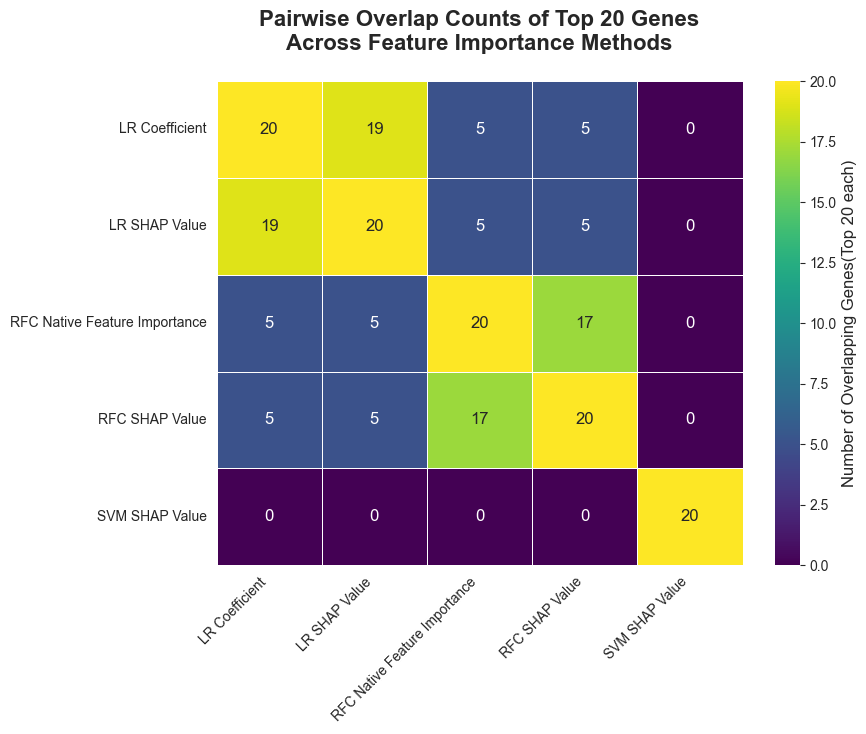

In [39]:
all_method_names = sorted(list(gene_sets.keys()))
overlap_matrix = pd.DataFrame(0, index=all_method_names, columns=all_method_names)

for method1, method2 in itertools.combinations(all_method_names, 2):
    overlap_count = len(gene_sets[method1].intersection(gene_sets[method2]))
    overlap_matrix.loc[method1, method2] = overlap_count
    overlap_matrix.loc[method2, method1] = overlap_count

for method in all_method_names:
    overlap_matrix.loc[method, method] = len(gene_sets[method])

fig_heatmap, ax_heatmap = plt.subplots(figsize=(9, 7.5))

sns.heatmap(
    overlap_matrix,
    annot=True,
    fmt='d',
    cmap='viridis',
    linewidths=.5,
    cbar_kws={'label': f'Number of Overlapping Genes'
                       f'(Top {N_GENES_FOR_CONSOLIDATION} each)'}
)

ax_heatmap.set_title(
    f'Pairwise Overlap Counts of Top {N_GENES_FOR_CONSOLIDATION} Genes\n'
    f'Across Feature Importance Methods\n'
)

ax_heatmap.tick_params(axis='x', rotation=45)
ax_heatmap.tick_params(axis='y', rotation=0)
plt.setp(ax_heatmap.get_xticklabels(), ha='right')

fig_heatmap.tight_layout()
fig_heatmap.savefig(
    f'pairwise_overlap_heatmap_top_{N_GENES_FOR_CONSOLIDATION}.pdf',
    dpi=300,
    bbox_inches='tight'
)
plt.show()

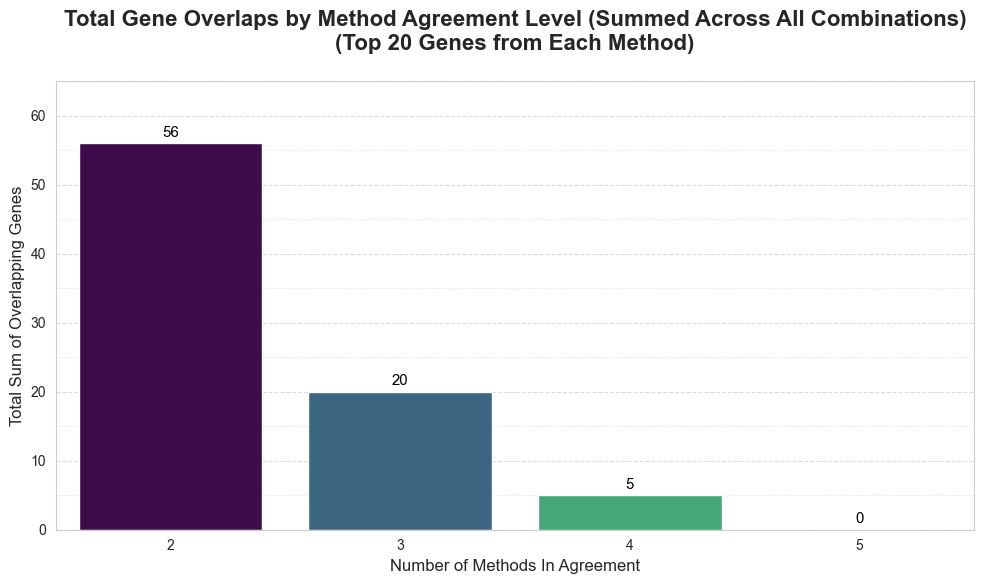

In [40]:
overlap_counts_by_num_methods = []
for num_to_combine in range(2, len(gene_sets.keys()) + 1):
    current_total_overlap = 0
    for combo in itertools.combinations(list(gene_sets.keys()), num_to_combine):
        overlap = set.intersection(*[gene_sets[method] for method in combo])
        current_total_overlap += len(overlap)

    overlap_counts_by_num_methods.append({
        'Num_Methods': num_to_combine,
        'Total_Overlap_Count': current_total_overlap
    })

df_overlap_counts_bar = pd.DataFrame(overlap_counts_by_num_methods)

fig_bar_total, ax_bar_total = plt.subplots(figsize=(10, 6))

sns.barplot(
    x='Num_Methods',
    y='Total_Overlap_Count',
    data=df_overlap_counts_bar,
    palette='viridis',
    hue='Num_Methods',
    legend=False,
    ax=ax_bar_total
)

ax_bar_total.set_title(
    f'Total Gene Overlaps by Method Agreement Level (Summed Across All Combinations)\n'
    f'(Top {N_GENES_FOR_CONSOLIDATION} Genes from Each Method)\n'
)
ax_bar_total.set_xlabel('Number of Methods In Agreement')
ax_bar_total.set_ylabel('Total Sum of Overlapping Genes')

ax_bar_total.set_ylim(0, 65)
ax_bar_total.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax_bar_total.yaxis.set_minor_locator(ticker.MultipleLocator(5))

ax_bar_total.grid(which='major', axis='y', linestyle='--', alpha=0.7)
ax_bar_total.grid(which='minor', axis='y', linestyle=':', alpha=0.6)
ax_bar_total.grid(axis='x', visible=False)

for container in ax_bar_total.containers:
    for bar in container:
        height = bar.get_height()
        ax_bar_total.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.5,
            f'{int(height)}',
            ha='center',
            va='bottom',
            color='black',
            fontsize=plt.rcParams['font.size'] * 0.9
        )

fig_bar_total.tight_layout()
fig_bar_total.savefig(
    f'total_overlap_counts_bar_top_{N_GENES_FOR_CONSOLIDATION}.pdf',
    dpi=300,
    bbox_inches='tight'
)
plt.show()

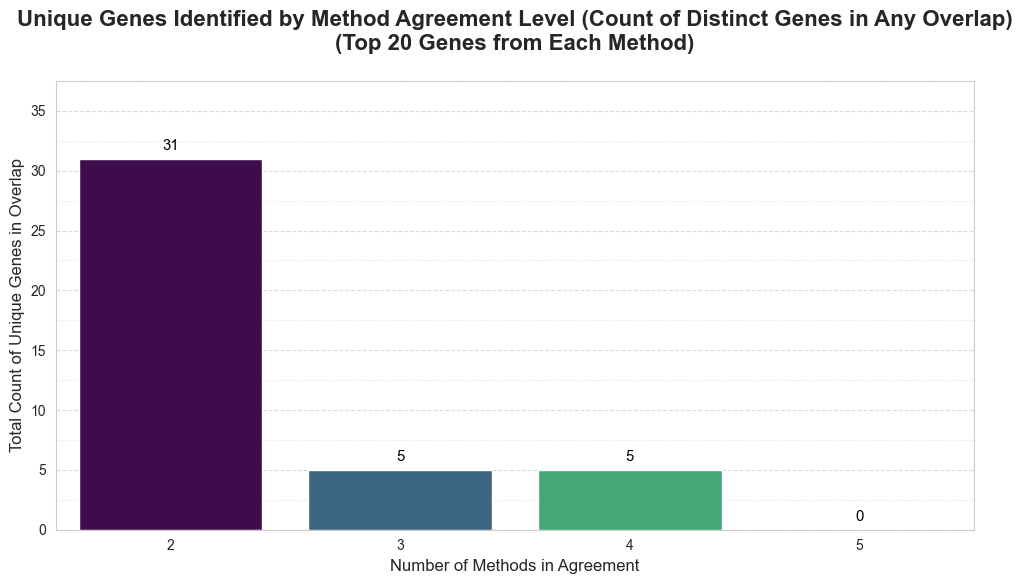

In [41]:
unique_overlap_counts_by_num_methods = []
for num_to_combine in range(2, len(gene_sets.keys()) + 1):
    unique_genes_at_this_level = set()
    for combo in itertools.combinations(list(gene_sets.keys()), num_to_combine):
        overlap = set.intersection(*[gene_sets[method] for method in combo])
        unique_genes_at_this_level.update(overlap)

    unique_overlap_counts_by_num_methods.append({
        'Num_Methods': num_to_combine,
        'Unique_Overlap_Count': len(unique_genes_at_this_level)
    })

df_unique_overlap_counts_bar = pd.DataFrame(unique_overlap_counts_by_num_methods)

fig_bar_unique, ax_bar_unique = plt.subplots(figsize=(10, 6))

sns.barplot(
    x='Num_Methods',
    y='Unique_Overlap_Count',
    data=df_unique_overlap_counts_bar,
    palette='viridis',
    hue='Num_Methods',
    legend=False,
    ax=ax_bar_unique
)

ax_bar_unique.set_title(
    f'Unique Genes Identified by Method Agreement Level (Count of Distinct Genes in Any Overlap)\n'
    f'(Top {N_GENES_FOR_CONSOLIDATION} Genes from Each Method)\n'
)
ax_bar_unique.set_xlabel('Number of Methods in Agreement')
ax_bar_unique.set_ylabel('Total Count of Unique Genes in Overlap')

ax_bar_unique.set_ylim(0, 37.5)
ax_bar_unique.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax_bar_unique.yaxis.set_minor_locator(ticker.MultipleLocator(2.5))

ax_bar_unique.grid(which='major', axis='y', linestyle='--', alpha=0.7)
ax_bar_unique.grid(which='minor', axis='y', linestyle=':', alpha=0.6)
ax_bar_unique.grid(axis='x', visible=False)

for container in ax_bar_unique.containers:
    for bar in container:
        height = bar.get_height()
        ax_bar_unique.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.5,
            f'{int(height)}',
            ha='center',
            va='bottom',
            color='black',
            fontsize=plt.rcParams['font.size'] * 0.9
        )

fig_bar_unique.tight_layout()
fig_bar_unique.savefig(
    f'unique_overlap_counts_bar_top_{N_GENES_FOR_CONSOLIDATION}.pdf',
    dpi=300,
    bbox_inches='tight'
)
plt.show()